**Importing all the necessary libraries**

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding,Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
import warnings
import json
import re

%matplotlib inline
pd.set_option('display.max_columns', 20)
warnings.filterwarnings('ignore')

Loading the training, validation and test set

In [2]:
train = pd.read_csv('../input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv')
val = pd.read_csv('../input/imdb-dataset-sentiment-analysis-in-csv-format/Valid.csv')
test = pd.read_csv('../input/imdb-dataset-sentiment-analysis-in-csv-format/Test.csv')

In [3]:
train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


Let's visualize the distribution of positive and negative comments in the training data.

Text(0.5, 1.0, 'Distribution of Positive and Negative labels')

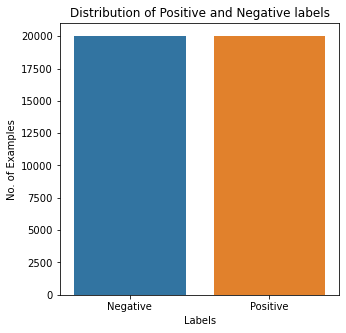

In [4]:
plt.figure(figsize=(5, 5))
sns.countplot(train.label.replace({0: 'Negative', 1: 'Positive'}))
plt.xlabel('Labels')
plt.ylabel('No. of Examples')
plt.title('Distribution of Positive and Negative labels')

It appears that the positive and negative labels are almost evenly distributed which means that the training data is not imbalanced.

**Data Preprocessing**

In [5]:
def process_comment(comment):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove hyperlinks
    comment = re.sub(r'https?:\/\/.*[\r\n]*', '', comment)
    # remove hashtags
    # only removing the hash # sign from the word
    comment = re.sub(r'#', '', comment)
    # tokenize comments
    comment_tokens = word_tokenize(comment)

    comment_clean = []
    for word in comment_tokens:
        if (word not in stopwords_english and word not in punctuation):
            stem_word = stemmer.stem(word)
            comment_clean.append(stem_word)

    return comment_clean

The process_comment function takes a string (comment) as an argument and process and cleans that comment to return a list of relevant words in that comment.

Example :- 

In [6]:
print('The original comment is : \n\n', train.text[0])
print('\nThe processed comment is : \n\n', process_comment(train.text[0]))

The original comment is : 

 I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.

The processed comment is : 

 ['I', 'grew', 'b', '1965', 'watch', 'love', 'thunderbird', 'all',

In [ ]:
# create the train, test and val data
train_data = []
test_data = []
val_data = []

for cmt_tr in train.text[:].tolist():
    train_data.append(process_comment(cmt_tr))
    
for cmt_tst in test.text[:].tolist():
    test_data.append(process_comment(cmt_tst))
    
for cmt_vl in val.text[:].tolist():
    val_data.append(process_comment(cmt_vl))

Creation of the train, val and test takes time so I already created them and stored them as a json file for later use.

Load the train, test and val files :-

In [7]:
with open('../input/dataset/data/train.json', 'r') as f1:
    train_data = json.load(f1)
    
with open('../input/dataset/data/test.json', 'r') as f2:
    test_data = json.load(f2)
    
with open('../input/dataset/data/val.json', 'r') as f3:
    val_data = json.load(f3)

In [8]:
# take all the comments as a single list of words
context = []

for cmt in train_data:
    context += cmt

In [9]:
# create frequency distribution of words
freq_dist = Counter(context)

In [128]:
# create the vocabulary
vocab = { '<pad>': 0, '<unk>': 1}
index = 2
for word in sorted(list(freq_dist.keys())):
    if freq_dist[word] > 2:
        vocab[word] = index
        index += 1

In [167]:
vocab_len = len(vocab.keys())
max_len = 150

In [168]:
# create numerical representation of train, test and val data
X_train = np.zeros((len(train_data), max_len))
X_test = np.zeros((len(test_data), max_len))
X_val = np.zeros((len(val_data), max_len))
idx1 = 0
idx2 = 0
idx3 = 0

for c1 in train_data:
    s1 = c1[:max_len]
    s1 = s1 + (['<pad>'] * (max_len - len(s1)))
    X_train[idx1, :] = np.array([vocab.get(w1, vocab['<unk>']) for w1 in s1])
    idx1 += 1

for c2 in test_data:
    s2 = c2[:max_len]
    s2 = s2 + (['<pad>'] * (max_len - len(s2)))
    X_test[idx2, :] = np.array([vocab.get(w2, vocab['<unk>']) for w2 in s2])
    idx2 += 1
    
for c3 in val_data:
    s3 = c3[:max_len]
    s3 = s3 + (['<pad>'] * (max_len - len(s3)))
    X_val[idx3, :] = np.array([vocab.get(w3, vocab['<unk>']) for w3 in s3])
    idx3 += 1

y_train = np.array(train.label)
y_test = np.array(test.label)
y_val = np.array(val.label)

In [169]:
batch_size = 64
steps_per_epoch = len(X_train) / batch_size

In [173]:
# create the model
model = Sequential()
model.add(Embedding(input_dim=vocab_len, output_dim=64, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [174]:
# compile the model
model.compile(optimizer=Adam(0.0001), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [175]:
# train the model
history = model.fit(X_train, y_train, verbose=1, epochs=4, steps_per_epoch=steps_per_epoch, batch_size=batch_size, validation_data=(X_val, y_val), use_multiprocessing=True, workers=10)

Epoch 1/4
625/625 [==============================] - 29s 47ms/step - loss: 0.6930 - accuracy: 0.5092 - val_loss: 0.6926 - val_accuracy: 0.5282
Epoch 2/4
625/625 [==============================] - 28s 45ms/step - loss: 0.4532 - accuracy: 0.7663 - val_loss: 0.3122 - val_accuracy: 0.8690
Epoch 3/4
625/625 [==============================] - 28s 45ms/step - loss: 0.2321 - accuracy: 0.9114 - val_loss: 0.2859 - val_accuracy: 0.8800
Epoch 4/4
625/625 [==============================] - 28s 45ms/step - loss: 0.1677 - accuracy: 0.9419 - val_loss: 0.3065 - val_accuracy: 0.8816


Plot the Accuracy and loss of training and validation data.

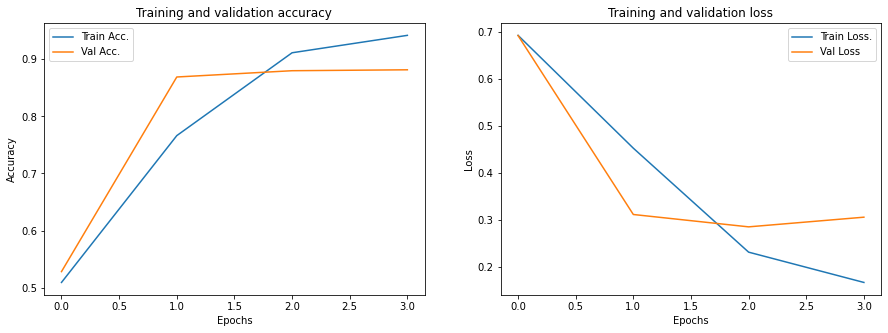

In [176]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot([i for i in range(len(history.history['accuracy']))], history.history['accuracy'], label='Train Acc.')
plt.plot([i for i in range(len(history.history['val_accuracy']))], history.history['val_accuracy'], label='Val Acc.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in range(len(history.history['loss']))], history.history['loss'], label='Train Loss.')
plt.plot([i for i in range(len(history.history['val_loss']))], history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()

In [177]:
# save the weights
model.save_weights('weights.h5')

In [178]:
# prediction on test set
pred = model.predict(X_test)

In [179]:
# calculate the Accuracy on test set
prediction = np.where(pred >= 0.5, 1, 0).squeeze()
test_accuracy = np.sum(prediction == y_test) / prediction.size
print(test_accuracy)

0.8754


* Training Accuracy   : **94.19 %**
* Validation Accuracy : **88.16 %**
* Test Accuracy       : **87.54 %**

In [127]:
# Test your own input
comment = input('Enter your review : ')
review = process_comment(comment)
review = review[:max_len]
review = review + (['<pad>'] * (max_len - len(review)))
review = np.array([vocab.get(w, vocab['<unk>']) for w in review])
sentiment = model.predict(np.array(review).reshape((1, max_len)))
print('\nReview :', comment)
if np.squeeze(sentiment) >= 0.5:
    print('Sentiment : Positive')
else:
    print('Sentiment : Negative')

Enter your review : not good

Review : not good
[15996     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
0.110993944
Sentiment : Negative


In [ ]:
model.summary()